# Pattern search

In [1]:
from matplotlib.colors import ListedColormap
from sklearn import cross_validation, datasets, metrics, tree ,ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve
import pandas as pd
import numpy as np
%pylab inline

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


## Генерация данных


In [2]:
datas = pd.read_csv('XBTUSD_20170101_20180226.csv')
# beginnig in 20171215 8: 56 :00
datas = datas.drop(['<TICKER>','<PER>'], axis =1)
#pyplot.plot(np.linspace(0,100,106000),datas['<OPEN>'])
#datas = datas.drop(range(0,5000), axis =0)
datas.head()


,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOLUME>
0,20170101,30000,968.29,968.29,968.29,968.29,0.0
1,20170101,30100,968.29,968.76,968.49,968.70,12993.0
2,20170101,30200,968.70,968.70,967.20,968.43,73800.0
3,20170101,30300,968.43,968.00,967.21,967.21,3500.0
4,20170101,30400,967.21,967.21,966.74,966.97,15969.0


In [3]:
# проценты от средней
def mean_period(datas, period):
    averages = []
    for i in np.arange(period,datas.shape[0],period):
        averages.append(datas['<OPEN>'][i-period:i].mean())
    averages.append(datas['<OPEN>'][i:datas.shape[0]].mean())
    return averages
    
def make_serias(datas,period,bound,averages):
    current_price = datas['<OPEN>'][0]
    result_series = [] 
    #print(averages)
    
    for i in range(datas.shape[0]):
        j = i / period
        #print(j)
        if current_price+averages[j]*bound/100.0<datas['<OPEN>'][i]:
            current_price = current_price + averages[j]*bound/100.0
            result_series.append(1)
            
        elif current_price - averages[j]*bound/100.0>datas['<OPEN>'][i]:
            current_price = current_price - averages[j]*bound/100.0
            result_series.append(-1)
    return result_series   

def make_series_equal(datas,step):
    current_price = datas['<OPEN>'][0]
    result_series = [] 
    for i in range(datas.shape[0]):
        if current_price + step < datas['<OPEN>'][i]:
            current_price = current_price + step
            result_series.append(1)
        elif current_price - step > datas['<OPEN>'][i]:
            current_price = current_price - step
            result_series.append(-1)
    return result_series   

def prob_a_z(series):
    a= 0 
    z =0 
    for i in range(len(series)):
        if series[i] > 0:
            a = a+1
        if series[i] < 0:
            z = z+1
    return {'success' : a,
            'failure' : z,
            'prob of success': float(a)/(a+z)}

def make_past(serias,len_of_past):
    data = []
    y = []
    for i in range(len_of_past,len(series)):
        data.append(series[i - len_of_past:i])
        y.append(series[i])
    return [np.array(data),np.array(y)]
        

In [4]:
bound = 5
period = 60
rounding = 1.0
len_of_past = 10
step = 200
series = make_series_equal(datas,step)
print prob_a_z(series)
data = make_past(series,len_of_past)
X = data[0]
y = data[1]


{'failure': 1307, 'prob of success': 0.5086466165413533, 'success': 1353}


In [5]:
#sum(y)

In [6]:
#подготовка данных для обучения
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(X, 
                                                                                     y, test_size = 0.3,
                                                                                     random_state = 1000, stratify = y)

len(X)


print(sum(test_labels))
print(sum(train_labels))

13
29


# Решающее дерево

In [7]:
# обучение дерева :

#tree_class = ensemble.RandomForestClassifier(max_depth=4,criterion='entropy' , n_estimators=150, random_state= 10)#,class_weight='balanced')
tree_class = ensemble.RandomForestClassifier(max_depth=4,criterion='gini' , n_estimators=150)
tree_class.fit(train_data, train_labels)
result = cross_validation.cross_val_score(tree_class, X,y, cv = 10 )


In [8]:
result.mean()

0.54223606830111293

In [9]:
print tree_class.feature_importances_
print metrics.accuracy_score(test_labels,tree_class.predict(test_data))
print metrics.precision_score(test_labels,tree_class.predict(test_data))
print metrics.recall_score(test_labels,tree_class.predict(test_data))

[ 0.05101217  0.07159544  0.07475187  0.08126223  0.06511151  0.07721717
  0.07764687  0.08569713  0.10309622  0.3126094 ]
0.547169811321
0.552631578947
0.571782178218


In [10]:
print test_labels[0:20]
print tree_class.predict(test_data)[0:20]

[-1  1  1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1]
[ 1  1 -1 -1 -1  1  1 -1  1  1 -1 -1  1  1  1  1 -1 -1  1  1]


# Logistic regression

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
optimizer = LogisticRegression(penalty ='l1')
optimizer.fit(train_data, train_labels)
Z = optimizer.predict(test_data)
print test_labels[0:20]
print Z[0:20]
print optimizer.coef_
print metrics.accuracy_score(test_labels,Z)
print metrics.precision_score(test_labels,Z)
print metrics.recall_score(test_labels,Z)

[-1  1  1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1]
[ 1  1 -1 -1 -1  1  1 -1  1  1 -1 -1  1  1  1  1 -1 -1  1  1]
[[-0.00349342 -0.002439    0.07177821 -0.0575338  -0.01858587 -0.03785455
  -0.037565    0.05019402 -0.1120325   0.22964868]]
0.566037735849
0.570743405276
0.589108910891


In [13]:
result = cross_validation.cross_val_score(optimizer,X,y,cv =7)

In [14]:
result

array([ 0.54210526,  0.56315789,  0.52645503,  0.5978836 ,  0.55291005,
        0.55291005,  0.49206349])

 Здесь стоит еще сделать GRIDSV

# K-neighbors 

In [15]:
from  sklearn.neighbors import KNeighborsClassifier

In [16]:
classifier = KNeighborsClassifier(n_neighbors=100)

In [17]:
classifier.fit(train_data, train_labels)
Q = classifier.predict(test_data)
print test_labels[0:20]
print Q[0:20]
#print classifier.predict_proba(test_data)
print metrics.accuracy_score(test_labels,Q)
print metrics.precision_score(test_labels,Q)
print metrics.recall_score(test_labels,Q)

[-1  1  1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1]
[ 1  1  1  1 -1  1  1  1  1  1 -1 -1 -1 -1  1 -1 -1  1  1  1]
0.523270440252
0.530266343826
0.542079207921


In [18]:
accuracy = []
precision = []
recall = []
for i in range(1,100):
    #print i,
    classifier_test = KNeighborsClassifier(n_neighbors=i)
    classifier_test.fit(train_data, train_labels)
    l = classifier_test.predict(test_data)
    accuracy.append(metrics.accuracy_score(test_labels,l))
    precision.append(metrics.precision_score(test_labels,l))
    recall.append(metrics.recall_score(test_labels,l))    

In [19]:
neighbors = np.arange(1,100,1)

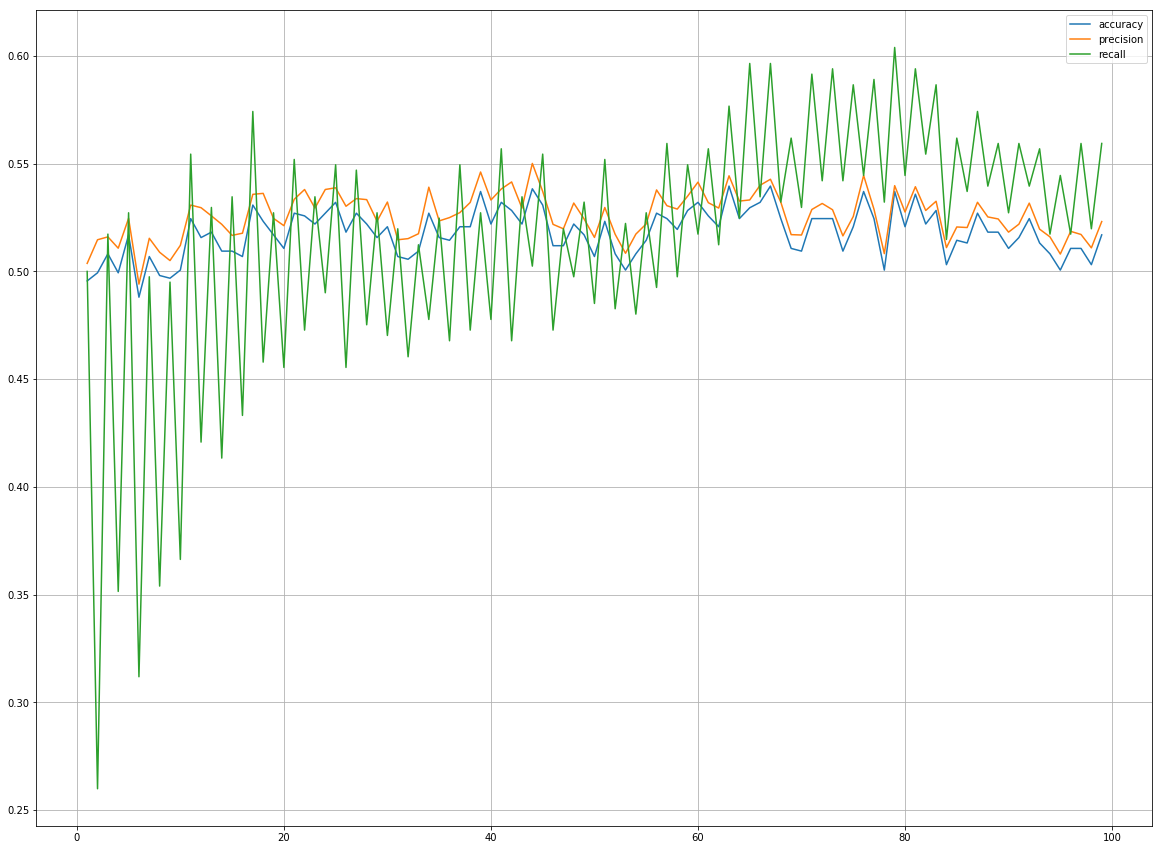

In [20]:
plt.figure(figsize=(20,15))
plt.plot(neighbors, accuracy, label ='accuracy')
plt.plot(neighbors, precision, label='precision')
plt.plot(neighbors, recall, label ='recall')
plt.grid()
plt.legend()

In [21]:
bound = 5
period = 60
rounding = 1.0
len_of_past = 10
step = 200
series = make_series_equal(datas,step)
print prob_a_z(series)
data = make_past(series,len_of_past)
X = data[0]
y = data[1]



{'failure': 1307, 'prob of success': 0.5086466165413533, 'success': 1353}


In [22]:
def find_prob_after_pattern(series,len_of_pat, future_step):
    patterns = [[(i/(2**j)%2*2 - 1)  for j in range(len_of_pat)] for i in range(2**len_of_pat)]
    number_of_patterns = [[0,0,0] for i in range(len(patterns))]  # [pos, neg]
    itr = 0
    for pat in patterns:
        number_of_patterns_pos = 0
        number_of_patterns_neg = 0
        for j in np.arange(len_of_pat,len(series)-future_step,10):
            if pat == series[j - len_of_pat:j]:
                if series[j-1+future_step]==1:   
                    number_of_patterns_pos += 1
                else:
                    number_of_patterns_neg += 1       
        number_of_patterns[itr][0] = float(number_of_patterns_pos)/(number_of_patterns_neg+number_of_patterns_pos)
        number_of_patterns[itr][1] = float(number_of_patterns_neg)/(number_of_patterns_neg+number_of_patterns_pos)
        number_of_patterns[itr][2] = number_of_patterns_neg+number_of_patterns_pos
        itr += 1
        #print number_of_patterns
    di = {str(patterns[i]) : number_of_patterns[i] for i in range(2**len_of_pat) }
    return di
    

In [23]:
find_prob_after_pattern(series,4,1)

{'[-1, -1, -1, -1]': [0.43478260869565216, 0.5652173913043478, 23],
 '[-1, -1, -1, 1]': [0.8235294117647058, 0.17647058823529413, 17],
 '[-1, -1, 1, -1]': [0.5263157894736842, 0.47368421052631576, 19],
 '[-1, -1, 1, 1]': [0.47619047619047616, 0.5238095238095238, 21],
 '[-1, 1, -1, -1]': [0.5625, 0.4375, 16],
 '[-1, 1, -1, 1]': [0.6666666666666666, 0.3333333333333333, 12],
 '[-1, 1, 1, -1]': [0.6666666666666666, 0.3333333333333333, 9],
 '[-1, 1, 1, 1]': [0.5555555555555556, 0.4444444444444444, 18],
 '[1, -1, -1, -1]': [0.375, 0.625, 16],
 '[1, -1, -1, 1]': [0.6666666666666666, 0.3333333333333333, 18],
 '[1, -1, 1, -1]': [0.16666666666666666, 0.8333333333333334, 6],
 '[1, -1, 1, 1]': [0.5909090909090909, 0.4090909090909091, 22],
 '[1, 1, -1, -1]': [0.375, 0.625, 16],
 '[1, 1, -1, 1]': [0.4, 0.6, 15],
 '[1, 1, 1, -1]': [0.3333333333333333, 0.6666666666666666, 15],
 '[1, 1, 1, 1]': [0.5652173913043478, 0.43478260869565216, 23]}

In [24]:
find_prob_after_pattern(series,3,1)

{'[-1, -1, -1]': [0.425, 0.575, 40],
 '[-1, -1, 1]': [0.525, 0.475, 40],
 '[-1, 1, -1]': [0.42857142857142855, 0.5714285714285714, 28],
 '[-1, 1, 1]': [0.6666666666666666, 0.3333333333333333, 27],
 '[1, -1, -1]': [0.5294117647058824, 0.47058823529411764, 34],
 '[1, -1, 1]': [0.7857142857142857, 0.21428571428571427, 28],
 '[1, 1, -1]': [0.4838709677419355, 0.5161290322580645, 31],
 '[1, 1, 1]': [0.6052631578947368, 0.39473684210526316, 38]}

In [25]:
find_prob_after_pattern(series,2,1)

{'[-1, -1]': [0.5, 0.5, 80],
 '[-1, 1]': [0.4909090909090909, 0.509090909090909, 55],
 '[1, -1]': [0.45161290322580644, 0.5483870967741935, 62],
 '[1, 1]': [0.5507246376811594, 0.4492753623188406, 69]}

In [26]:
find_prob_after_pattern(series,1,1)

{'[-1]': [0.4074074074074074, 0.5925925925925926, 135],
 '[1]': [0.5267175572519084, 0.4732824427480916, 131]}

In [27]:
#len(series)